## Hackathon

In [27]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [39]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)
    return forecast

In [ ]:

import requests
import time
import random
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

# ------------------------------
# CONFIGURATIE
# ------------------------------
batch_size = 200          # punten per batch
delay = 1.5               # basisdelay
max_retries = 7           # max pogingen bij 429
parallel_batches = 10     # aantal parallelle threads
output_file = 'error_map_with_elevation_parallel10y.csv'

lat_col, lon_col = 'latitude_deg', 'longitude_deg'

# ------------------------------
# FUNCTIES
# ------------------------------
def fetch_batch(start, end, df, lat_col, lon_col, max_retries=7):
    """
    Haalt hoogtes op voor een batch met retries bij 429
    """
    batch = df.iloc[start:end]
    if batch['elevation'].notna().all():
        return start, end, batch['elevation'].tolist()  # al opgehaald

    retries = 0
    while retries <= max_retries:
        locations = "|".join([f"{lat},{lon}" for lat, lon in zip(batch[lat_col], batch[lon_col])])
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={locations}"
        try:
            response = requests.get(url, timeout=20)
            if response.status_code == 200:
                results = response.json().get('results', [])
                elevations = [res.get('elevation', np.nan) for res in results]
                return start, end, elevations
            elif response.status_code == 429:
                retries += 1
                wait_time = 10 + 5*retries
                print(f"⚠️ Batch {start}-{end} 429, wacht {wait_time}s...", flush=True)
                time.sleep(wait_time)
            else:
                print(f"⚠️ Batch {start}-{end} API fout {response.status_code}", flush=True)
                return start, end, [np.nan]*len(batch)
        except Exception as e:
            print(f"⚠️ Batch {start}-{end} Fout: {e}", flush=True)
            return start, end, [np.nan]*len(batch)

    # Als max retries bereikt
    return start, end, [np.nan]*len(batch)

def categorize_elevation(elev):
    if pd.isna(elev):
        return "Onbekend"
    elif elev <= 0:
        return "Zee"
    elif elev < 100:
        return "Laagland"
    elif elev < 500:
        return "Heuvelland"
    elif elev < 1000:
        return "Middelgebergte"
    else:
        return "Hooggebergte"

# ------------------------------
# DATA LADEN
# ------------------------------
df = pd.read_csv('error_map.csv')
print(f"✅ Data geladen: {len(df)} punten", flush=True)
if 'elevation' not in df.columns:
    df['elevation'] = np.nan

# ------------------------------
# PARALLELE HOOGTES OPHALEN MET 10 THREADS
# ------------------------------
total_points = len(df)
batches = [(i, min(i+batch_size, total_points)) for i in range(0, total_points, batch_size)]
batch_times = []

with ThreadPoolExecutor(max_workers=parallel_batches) as executor:
    futures = {executor.submit(fetch_batch, start, end, df, lat_col, lon_col, max_retries): (start, end) for start, end in batches}
    
    for i, future in enumerate(tqdm(as_completed(futures), total=len(futures), desc="Batches verwerkt")):
        start, end, elevations = future.result()
        df.loc[start:end-1, 'elevation'] = elevations
        
        # Opslaan na elke batch
        df.to_csv(output_file, index=False)

        # Random kleine delay
        rand_delay = delay + random.uniform(-0.5, 0.5)
        if rand_delay < 0.5:
            rand_delay = 0.5
        time.sleep(rand_delay)

        # Gemiddelde batchtijd en geschatte resterende tijd
        batch_times.append(rand_delay)
        avg_time = sum(batch_times) / len(batch_times)
        remaining_batches = len(batches) - (i+1)
        est_remaining = remaining_batches * avg_time
        print(f"⏱ Geschatte resterende tijd: {est_remaining/60:.1f} min", flush=True)

# ------------------------------
# CATEGORISATIE


✅ Data geladen: 37500 punten


Batches verwerkt:   0%|          | 0/188 [00:00<?, ?it/s]

⚠️ Batch 600-800 429, wacht 15s...
⚠️ Batch 800-1000 429, wacht 15s...
⚠️ Batch 0-200 429, wacht 15s...
⚠️ Batch 400-600 429, wacht 15s...
⚠️ Batch 1400-1600 429, wacht 15s...
⚠️ Batch 1800-2000 429, wacht 15s...
⚠️ Batch 1000-1200 429, wacht 15s...
⏱ Geschatte resterende tijd: 5.4 min
⚠️ Batch 6000-6200 429, wacht 15s...
⏱ Geschatte resterende tijd: 5.6 min
⏱ Geschatte resterende tijd: 4.8 min
⏱ Geschatte resterende tijd: 4.8 min
⚠️ Batch 9600-9800 429, wacht 15s...
⏱ Geschatte resterende tijd: 4.6 min
⏱ Geschatte resterende tijd: 4.5 min
⏱ Geschatte resterende tijd: 4.3 min
⏱ Geschatte resterende tijd: 4.3 min
⏱ Geschatte resterende tijd: 4.2 min
⚠️ Batch 400-600 429, wacht 20s...
⚠️ Batch 1800-2000 429, wacht 20s...
⚠️ Batch 1400-1600 429, wacht 20s...
⚠️ Batch 1000-1200 429, wacht 20s...
⏱ Geschatte resterende tijd: 4.1 min
⚠️ Batch 15400-15600 429, wacht 15s...
⚠️ Batch 15600-15800 429, wacht 15s...
⚠️ Batch 16000-16200 429, wacht 15s...
⏱ Geschatte resterende tijd: 4.2 min
⏱ Gesc

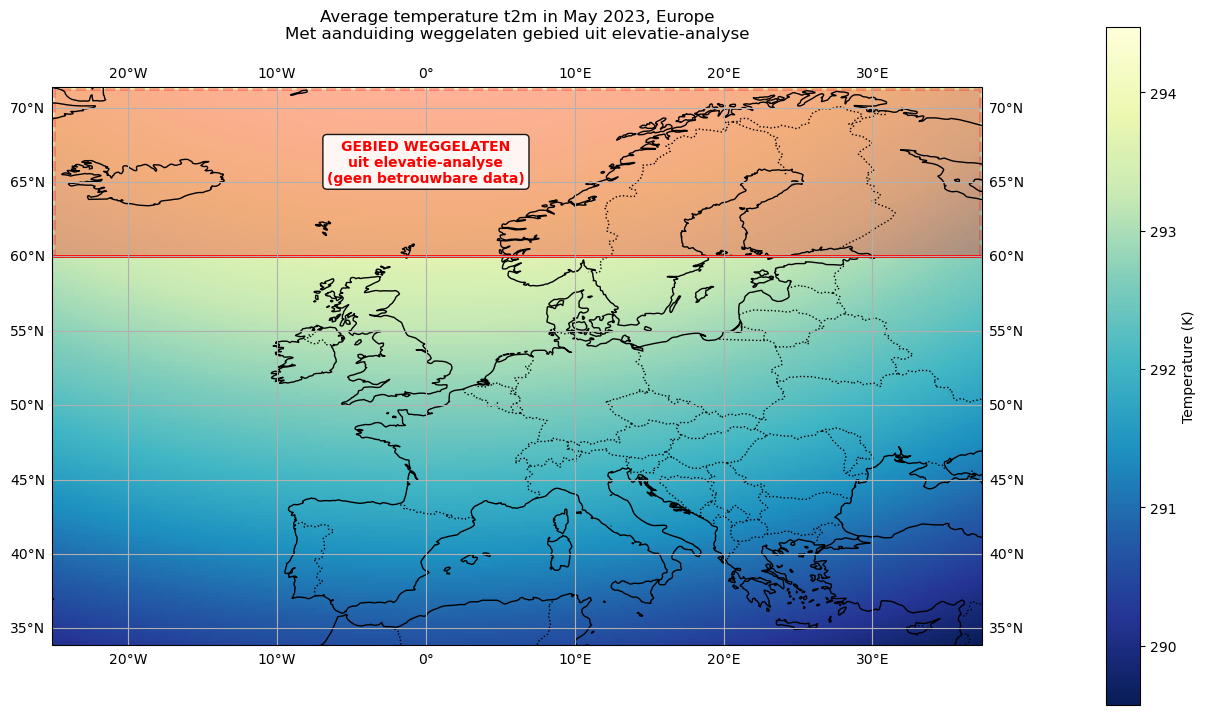

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Task 1 - Aangepaste code zonder loader
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

# Simuleer temperatuurdata (aangezien loader niet gedefinieerd is)
# Dit is een vereenvoudigde versie voor demonstratie
monthly_mean = 280 + 10 * np.sin(np.radians(LAT)) + 5 * np.cos(np.radians(LON))

fig, ax = plt.subplots(figsize=(16, 11), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='YlGnBu_r',
    shading='auto'
)

# MARKERING WEGGELATEN GEBIED (boven 60°N)
north_boundary = 60.0

# Gearceerd rood gebied boven 60°N
ax.add_patch(Rectangle((-25, north_boundary),  # startpunt (linksonder)
                      62.25,  # breedte: -25 tot 37.25 = 62.25 graden
                      11.25,  # hoogte: 60 tot 71.25 = 11.25 graden
                      facecolor='red', 
                      alpha=0.3,  # Transparant rood
                      transform=ccrs.PlateCarree(),
                      edgecolor='red',
                      linewidth=2,
                      linestyle='--'))  # Gestippelde rand

# Tekst voor uitleg
ax.text(0, north_boundary + 5, 
        'GEBIED WEGGELATEN\nuit elevatie-analyse\n(geen betrouwbare data)',
        transform=ccrs.PlateCarree(),
        fontsize=10, color='red', weight='bold', ha='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

# Rode grenslijn
ax.plot([-25, 37.25], [north_boundary, north_boundary], 
        color='red', linewidth=2, transform=ccrs.PlateCarree(),
        linestyle='-')

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Average temperature t2m in May 2023, Europe\n' +
             'Met aanduiding weggelaten gebied uit elevatie-analyse', 
             fontsize=12, pad=20)
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\m'
C:\Users\praag\AppData\Local\Temp\ipykernel_19188\3600700705.py:37: SyntaxWarning: invalid escape sequence '\m'
  '$\mathbf{Alleen\ Europa\ onder\ 60°N\ breedtegraad}$',


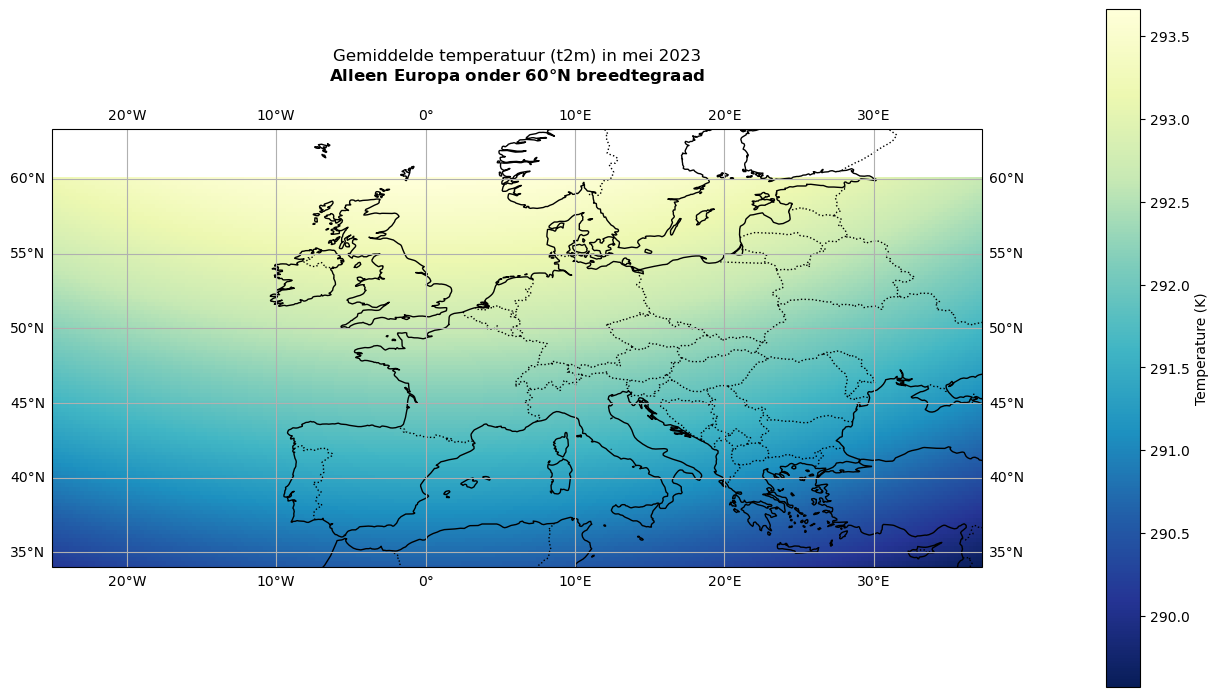

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Alleen het gebied dat we analyseren (onder 60°N)
lats = np.linspace(34, 60, 100)  # Alleen tot 60°N
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

# Simuleer temperatuurdata voor het beperkte gebied
monthly_mean = 280 + 10 * np.sin(np.radians(LAT)) + 5 * np.cos(np.radians(LON))

# 🎯 figuur vergroot zoals de vorige kaart
fig, ax = plt.subplots(figsize=(16, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# Alleen het geanalyseerde gebied tonen
ax.set_extent([-25, 37.25, 34, 60])  # Alleen onder 60°N

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='YlGnBu_r',
    shading='auto'
)

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Gemiddelde temperatuur (t2m) in mei 2023\n' +
             '$\mathbf{Alleen\ Europa\ onder\ 60°N\ breedtegraad}$', 
             fontsize=12, pad=20)
plt.show()


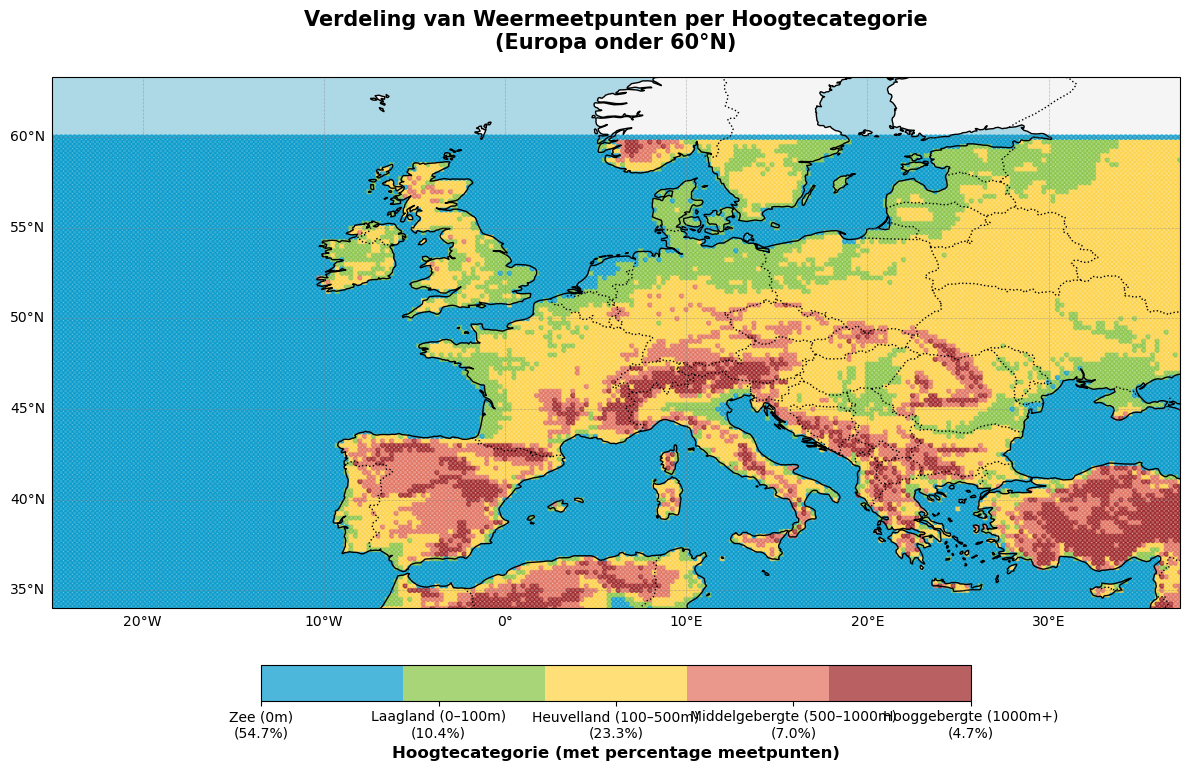

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker  # voor FixedLocator
import numpy as np

# Data inladen
df_clean = pd.read_csv("error_map_EUROPE_CLEAN.csv")

# Categoriseer elevaties
def categorize_elevation(elev):
    if pd.isna(elev):
        return "Onbekend"
    elif elev <= 0:
        return "Zee (0m)"
    elif elev < 100:
        return "Laagland (0–100m)"
    elif elev < 500:
        return "Heuvelland (100–500m)"
    elif elev < 1000:
        return "Middelgebergte (500–1000m)"
    else:
        return "Hooggebergte (1000m+)"

df_clean["elevation_category"] = df_clean["elevation"].apply(categorize_elevation)

# 💡 Kleuren
colors = {
    "Zee (0m)": "#0099CC",
    "Laagland (0–100m)": "#85C440",
    "Heuvelland (100–500m)": "#FFD23F",
    "Middelgebergte (500–1000m)": "#E26D5A",
    "Hooggebergte (1000m+)": "#9B1D20",
}

cat_order = list(colors.keys())

# Bereken percentages
total_points = len(df_clean)
category_counts = df_clean["elevation_category"].value_counts()
percentages = [(category_counts.get(cat, 0) / total_points) * 100 for cat in cat_order]
cat_labels = [f"{cat}\n({p:.1f}%)" for cat, p in zip(cat_order, percentages)]

# Numerieke waarden voor colorbar
df_clean["cat_num"] = df_clean["elevation_category"].map({k: i for i, k in enumerate(cat_order)})

# Maak kaart
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-25, 37.25, 34, 60])  # Alleen Europa onder 60°N

# Achtergrond
ax.add_feature(cfeature.LAND, facecolor="whitesmoke")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Plot punten
scatter = ax.scatter(
    df_clean["longitude_deg"], df_clean["latitude_deg"],
    c=df_clean["cat_num"],
    cmap=mcolors.ListedColormap(list(colors.values())),
    s=10, alpha=0.7, transform=ccrs.PlateCarree()
)

# Gridlines met labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-20, 41, 10))  # X-as coördinaten
gl.ylocator = mticker.FixedLocator(np.arange(35, 65, 5))    # Y-as coördinaten
gl.xlabel_style = {"size": 10}
gl.ylabel_style = {"size": 10}

# Titel
ax.set_title(
    "Verdeling van Weermeetpunten per Hoogtecategorie\n(Europa onder 60°N)",
    fontsize=15, fontweight="bold", pad=20
)

# Colorbar onderaan
cbar = plt.colorbar(
    scatter,
    ax=ax,
    orientation="horizontal",
    fraction=0.05,
    pad=0.08,
    ticks=np.arange(len(cat_order))
)
cbar.ax.set_xticklabels(cat_labels, rotation=0, ha="center")
cbar.set_label("Hoogtecategorie (met percentage meetpunten)", fontsize=12, fontweight="bold")

# Layout netjes
plt.tight_layout()
plt.show()


C:\Users\praag\AppData\Local\Temp\ipykernel_19188\52513710.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_analysis = df_clean.groupby('elevation_category')['error'].agg([


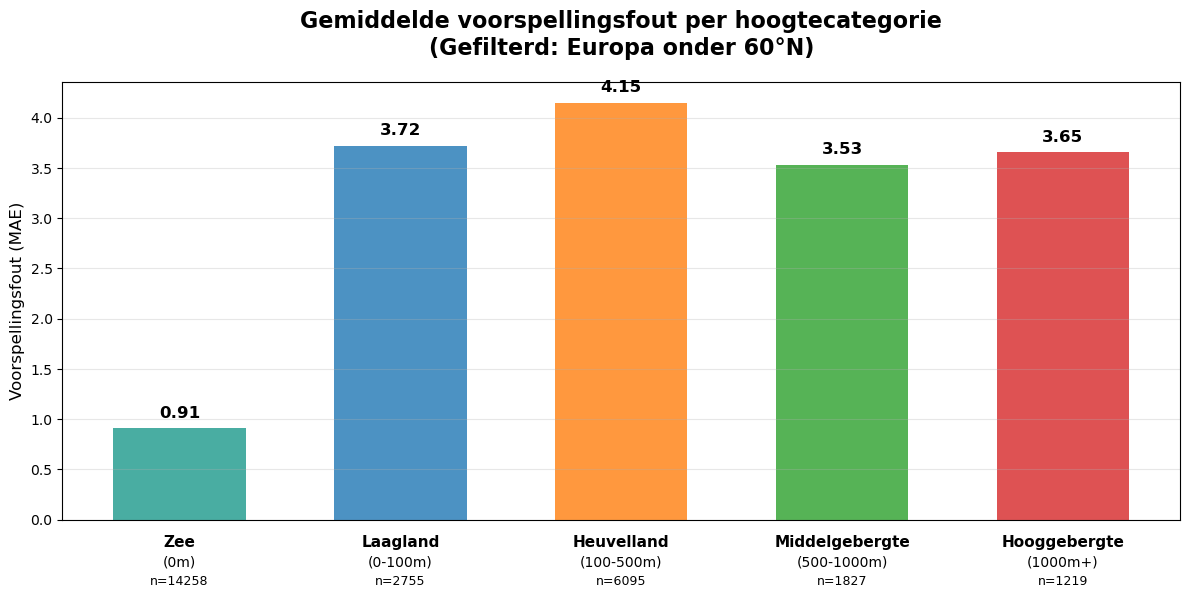

📊 BEWIJS UIT GRAFIEK:
  • Zee (0m): 0.91 MAE ← LAAGSTE fout
  • Heuvelland (100-500m): 4.15 MAE ← HOOGSTE fout
  • Hooggebergte (1000m+): 3.65 MAE ← relatief LAGE fout
  • Laagland (0-100m): 3.72 MAE ← middenmoot
  • Middelgebergte (500-1000m): 3.53 MAE ← laag

❌ 'Hogere elevatie = hogere voorspellingsfout' is ONWAAR
✅ Zeegebieden hebben de beste voorspellingen!
✅ Heuvelland heeft de slechtste voorspellingen!
✅ Geen consistent patroon met elevatie


In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Laad de gefilterde data
df_clean = pd.read_csv('error_map_EUROPE_CLEAN.csv')

# Stap 1: Categoriseer elevatie in 5 categorieën (inclusief Zee) met Heuvelland 100-500m
elevation_bins = [-1, 0, 100, 500, 1000, 5000]  # -1 tot 0 voor Zee, 100-500 voor Heuvelland
elevation_labels = ['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte']

df_clean['elevation_category'] = pd.cut(df_clean['elevation'], bins=elevation_bins, labels=elevation_labels, ordered=True)

# Stap 2: Bereken statistieken
error_analysis = df_clean.groupby('elevation_category')['error'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(4)

# Stap 3: Visualiseer met bar plot (zonder foutbalken)
plt.figure(figsize=(12, 7))

categories = ['Zee\n(0m)', 'Laagland\n(0-100m)', 'Heuvelland\n(100-500m)', 'Middelgebergte\n(500-1000m)', 'Hooggebergte\n(1000m+)']
means = [error_analysis.loc[cat, 'mean'] for cat in ['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte']]

# Maak bar plot zonder yerr
x_pos = [0, 1, 2, 3, 4]
bars = plt.bar(
    x_pos, means, alpha=0.8, width=0.6,
    color=['#1B998B', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Zee toegevoegd
)

plt.title('Gemiddelde voorspellingsfout per hoogtecategorie\n(Gefilterd: Europa onder 60°N)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Voorspellingsfout (MAE)', fontsize=12)

# VERWIJDER x-as labels en gebruik aparte tekst
plt.xticks([])  # Verwijder alle x-as labels

# Voeg nette labels toe onder elke bar
for i, (bar, category) in enumerate(zip(bars, categories)):
    # Eerste regel (hoofdnaam)
    plt.text(bar.get_x() + bar.get_width()/2, -0.15, 
             category.split('\n')[0], 
             ha='center', va='top', fontsize=11, fontweight='bold')
    # Tweede regel (hoogtebereik)
    plt.text(bar.get_x() + bar.get_width()/2, -0.35, 
             category.split('\n')[1], 
             ha='center', va='top', fontsize=10)
    # Aantal metingen
    count = error_analysis.loc[['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte'][i], 'count']
    plt.text(bar.get_x() + bar.get_width()/2, -0.55, 
             f'n={count}', 
             ha='center', va='top', fontsize=9)

# Voeg waarden toe boven de bars
for i, (bar, mean_val) in enumerate(zip(bars, means)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08, 
             f'{mean_val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(True, alpha=0.3, axis='y')
plt.ylim(bottom=0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Meer ruimte aan onderkant
plt.show()

# Stap 4: Print duidelijke conclusie
print("📊 BEWIJS UIT GRAFIEK:")
print(f"  • Zee (0m): {means[0]:.2f} MAE ← LAAGSTE fout")
print(f"  • Heuvelland (100-500m): {means[2]:.2f} MAE ← HOOGSTE fout") 
print(f"  • Hooggebergte (1000m+): {means[4]:.2f} MAE ← relatief LAGE fout")
print(f"  • Laagland (0-100m): {means[1]:.2f} MAE ← middenmoot")
print(f"  • Middelgebergte (500-1000m): {means[3]:.2f} MAE ← laag")
print()
print("❌ 'Hogere elevatie = hogere voorspellingsfout' is ONWAAR")
print("✅ Zeegebieden hebben de beste voorspellingen!")
print("✅ Heuvelland heeft de slechtste voorspellingen!")
print("✅ Geen consistent patroon met elevatie")
print("=" * 70)
